> # 공통 환경 처리

In [44]:
%pip install influxdb_client

Note: you may need to restart the kernel to use updated packages.


In [45]:
import os
import pandas as pd
from influxdb_client import InfluxDBClient
from datetime import datetime, timedelta
import matplotlib as mpl

# 한글 폰트 설정
mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False

> # 연결정보 및 기기 위치 매핑

### Influx DB 접속 정보 및 장치 위치 맵핑 정보

InfluxDB에 대한 연결 매개변수를 설정하고 장치 ID를 해당 위치에 매핑하여 데이터 검색을 구성합니다.

In [46]:
# InfluxDB 설정 정보
url = "http://133.186.144.22:8086"
token = "BPJ1pnKvoaov4Tte971t0zpRSTUXNZvrshU7u3UPheAIsBeUJEFfbKjfsZjtwZmugkHJEGRW17lH4bR9ybanNQ=="
org = "smoothing"

# 디바이스 ID와 위치를 매핑
location_mapping = {
    '24e124126d152919': 'indoor',
    '24e124126d152969': 'bottom_right_corner',
    '24e124128c067999': 'indoor',
    '24e124785c389818': 'bottom_left_corner',
    '24e124785c421885': 'top_right_corner'
}

> # 데이터 집계 기능

InfluxDB에서 데이터를 가져와 사용 가능한 형식으로 변환하고 추가 분석을 위해 결과를 저장하는 기능 및 프로세스입니다.

## 데이터 가져오기
사전에 정의된 쿼리 기반으로 InfluxDB에서 데이터를 검색하고 Pandas DataFrame로 구성

influx DB에서 데이터를 받아와 Time, Value, Place, Location, Device 컬럼 형태로 지정하였습니다.
 
데이터 종류는 전력데이터와 온도데이터를 받아 데이터 분석을 할 것 입니다.

In [47]:
# InfluxDB 클라이언트 생성
def create_client(url, token, org):
    return InfluxDBClient(url=url, token=token, org=org)

# 쿼리 실행 및 DataFrame으로 변환
def query_to_dataframe(client, query):
    result = client.query_api().query(query=query)
    results = []
    
    for table in result:
        for record in table.records:
            results.append({
                "time": record.get_time(),
                "value": record.get_value(),
                "place": record.values.get("place"),
                "location": record.values.get("location"),
                "device": record.values.get("device")
            })
    
    df = pd.DataFrame(results)
    df['time'] = df['time'].astype(str).str.replace(r'\+00:00$', '', regex=True)
    return df

# 데이터를 날짜를 지정하여 CSV 파일로 저장
def save_csv(df, file_pattern, directory):
    # 경로가 존재하는지 확인하고, 없다면 생성
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    current_date = datetime.now()
    previous_date = current_date - timedelta(days=1)
    filename = f"{directory}{previous_date.strftime(file_pattern)}"
    df.to_csv(filename, index=False)
    
# 온도 Data에서 'device' 열에 따라 'location' 열을 업데이트    
def update_location(df, location_mapping):
    df['location'] = df['device'].map(location_mapping)
    return df

### 각 데이터 조회 및 CSV변환 수행

In [83]:
# 클라이언트 생성 및 쿼리 실행
client = create_client(url, token, org)

# 전력 조회 Flux 쿼리
query_power_data = '''
import "date"
from(bucket: "powermetrics_data")
  |> range(start: date.sub(d: 1d, from: date.truncate(t: now(), unit: 1d)), stop: date.truncate(t: now(), unit: 1d))
  |> filter(fn: (r) => r["phase"] == "total")
  |> filter(fn: (r) => r["description"] == "w")
  |> filter(fn: (r) => r["place"] == "class_a" or r["place"] == "office")
  |> filter(fn: (r) => r["location"] != "main")
  |> aggregateWindow(every: 2m, fn: mean, createEmpty: false)
  |> keep(columns: ["_time", "_value", "place", "location", "device"])
'''

# CSV 변환
df_power = query_to_dataframe(client, query_power_data)
print(df_power.head())
save_csv(df_power, "%m_%d_power_data.csv", "power/")


# 온도 조회 Flux 쿼리
query_temperature_data = '''
import "date"
from(bucket: "environmentalsensors_data")
  |> range(start: date.sub(d: 1d, from: date.truncate(t: now(), unit: 1d)), stop: date.truncate(t: now(), unit: 1d))
  |> filter(fn: (r) => r["measurement"] == "temperature")
  |> filter(fn: (r) => r["place"] == "class_a" or r["place"] == "office")
  |> aggregateWindow(every: 2m, fn: mean, createEmpty: false)
  |> keep(columns: ["_time", "_value", "place", "location", "device"])
'''

# CSV 변환
df_temperature = query_to_dataframe(client, query_temperature_data)
df_temperature_fix = update_location(df_temperature, location_mapping)
print(df_temperature_fix.head())
save_csv(df_temperature_fix, "%m_%d_temperature_data.csv", "temperature/")

# 이산화탄소 조회 Flux 쿼리
query_co2_data = '''
import "date"
from(bucket: "environmentalsensors_data")
  |> range(start: date.sub(d: 1d, from: date.truncate(t: now(), unit: 1d)), stop: date.truncate(t: now(), unit: 1d))
  |> filter(fn: (r) => r["place"] == "class_a")
  |> filter(fn: (r) => r["measurement"] == "co2")
  |> aggregateWindow(every: 2m, fn: mean, createEmpty: false)
  |> keep(columns: ["_time", "_value", "place", "location", "device"])
'''

# CSV 변환
df_co2 = query_to_dataframe(client, query_co2_data)
df_co2_fix = update_location(df_co2, location_mapping)
print(df_co2_fix.head())
save_csv(df_co2_fix, "%m_%d_co2_data.csv", "co2/")

# 클라이언트 종료
client.close()

                  time  value   place   location     device
0  2024-04-27 00:02:00   29.5  office  a_project  gems-3500
1  2024-04-27 00:04:00   28.0  office  a_project  gems-3500
2  2024-04-27 00:06:00   28.0  office  a_project  gems-3500
3  2024-04-27 00:08:00   28.0  office  a_project  gems-3500
4  2024-04-27 00:10:00   28.0  office  a_project  gems-3500
                  time  value   place location            device
0  2024-04-27 00:02:00   24.2  office   indoor  24e124126d152919
1  2024-04-27 00:04:00   24.3  office   indoor  24e124126d152919
2  2024-04-27 00:06:00   24.3  office   indoor  24e124126d152919
3  2024-04-27 00:08:00   24.4  office   indoor  24e124126d152919
4  2024-04-27 00:10:00   24.4  office   indoor  24e124126d152919
                  time  value    place location            device
0  2024-04-27 00:02:00  669.0  class_a   indoor  24e124128c067999
1  2024-04-27 00:04:00  674.5  class_a   indoor  24e124128c067999
2  2024-04-27 00:06:00  684.0  class_a   indoor  24e

> # 데이터 전처리

데이터 전처리를 위해 결측치 제거와 이상치 제거를 할 것이다.

온도데이터와, 전력데이터 빈값이 있을 수 있으므로 결측치를 제거한다.

이상치는 어떠한 것을 위해 제거한다.

### 전체 데이터 병합 및 결측치 처리 함수

In [70]:
# 전체 데이터 병합
def merge_data(directory_path):
    # 디렉토리 내의 모든 CSV 파일 목록을 생성
    csv_files = [file for file in os.listdir(directory_path) if file.endswith('.csv')]

    # 모든 CSV 파일을 데이터 프레임으로 읽어와 하나로 병합
    data_frames = []
    for file in csv_files:
        file_path = os.path.join(directory_path, file)
        df = pd.read_csv(file_path)
        df['time'] = pd.to_datetime(df['time'])
        data_frames.append(df)

    # 모든 데이터 프레임을 하나로 병합
    merged_df = pd.concat(data_frames, ignore_index=True)

    # 원하는 컬럼만 선택
    columns_to_keep = ['time', 'value', 'place', 'location']
    filtered_df = merged_df[columns_to_keep]

    # 'place', 'time'으로 정렬
    sorted_df = filtered_df.sort_values(['place', 'time'])

    return sorted_df

# 결측치 확인 및 처리
def load_and_clean_data(df, output_directory_path, file_name):
    # 요약 사전 초기화
    file_summary = {}

    # 데이터프레임의 초기 형태 저장
    initial_shape = df.shape

    # 정리 전 총 결측치 수 계산
    missing_before = df.isnull().sum().sum()

    # 결측치 제거
    df.dropna(inplace=True)

    # 정리 후 결측치가 제거되었는지 확인하기 위해 결측치 수 다시 계산
    missing_after = df.isnull().sum().sum()

    # 요약 사전 업데이트
    file_summary["file"] = file_name
    file_summary["initial_rows"] = initial_shape[0]
    file_summary["final_rows"] = df.shape[0]
    file_summary["missing_removed"] = missing_before - missing_after

    # 출력 디렉토리가 존재하지 않는 경우 생성
    if not os.path.exists(output_directory_path):
        os.makedirs(output_directory_path)

    # 출력 파일 경로 구성
    output_file_path = os.path.join(output_directory_path, f"{file_name}_cleaned.csv")

    # 정리된 데이터프레임을 CSV로 저장
    df.to_csv(output_file_path, index=False)

    # 처리 결과 요약 출력
    print("\n--- 처리 결과 요약 ---\n")
    print(f"파일 이름: {file_summary['file']}, 초기 행 수: {file_summary['initial_rows']}, 최종 행 수: {file_summary['final_rows']}, 제거된 결측치 수: {file_summary['missing_removed']}")
    print("")

### 각 데이터 병합 수행 및 결측치 처리

In [87]:
power_path = 'power'
stats_values_df = merge_data(power_path)
print(stats_values_df.head())
load_and_clean_data(stats_values_df, "cleaned_data/power/", "power_stats")

temperature_path = 'temperature'
stats_values_df = merge_data(temperature_path)
print(stats_values_df.head())
load_and_clean_data(stats_values_df, "cleaned_data/temperature/", "temperature_stats")

co2_path = 'co2'
stats_values_df = merge_data(co2_path)
print(stats_values_df.head())
load_and_clean_data(stats_values_df, "cleaned_data/co2/", "co2_stats")

                     time  value    place                 location
59760 2024-04-15 00:02:00   23.5  class_a           ac_indoor_unit
61200 2024-04-15 00:02:00  112.5  class_a          ac_outdoor_unit
63360 2024-04-15 00:02:00    8.0  class_a           automatic_door
72720 2024-04-15 00:02:00    0.0  class_a  outdoor_unit_room_light
59761 2024-04-15 00:04:00   23.5  class_a           ac_indoor_unit

--- 처리 결과 요약 ---

파일 이름: power_stats, 초기 행 수: 252336, 최종 행 수: 252336, 제거된 결측치 수: 0

                     time  value    place             location
23990 2024-04-15 00:02:00  23.10  class_a  bottom_right_corner
24696 2024-04-15 00:02:00  23.85  class_a               indoor
25416 2024-04-15 00:02:00  23.50  class_a   bottom_left_corner
26136 2024-04-15 00:02:00  23.40  class_a     top_right_corner
23991 2024-04-15 00:04:00  23.20  class_a  bottom_right_corner

--- 처리 결과 요약 ---

파일 이름: temperature_stats, 초기 행 수: 38219, 최종 행 수: 38219, 제거된 결측치 수: 0

                    time  value    place locat

> ### 전력, 온도 데이터의 연관 관계 측정

전력과 온도 데이터를 가지고 연관관계를 측정 해볼 하여 수치가 얼마나 나오는지 확인 해볼 것입니다.

조건은 평균 전력 사용량과 평균 온도를 계산하여 두 데이터 프레임을 시간대 기준으로 결합하여 상관관계에 대해 수치를 나타내 확인 해보니 아래와 같이 결과 수치가 나왔다는 것을 볼 수 있습니다.

아래 결과 수치를 보니 연관성이 있다는 것을 확인 할 수 있습니다.

In [78]:
# 전력 사용량 데이터와 환경 센서 데이터를 로드합니다.
temperature_df = pd.read_csv('cleaned_data/temperature/temperature_stats_cleaned.csv')
power_df = pd.read_csv('cleaned_data/power/power_stats_cleaned.csv')

# 시간대별로 그룹화하여 각 시간대의 평균 전력 사용량을 계산합니다.
power_avg = power_df.groupby('time').value.mean().reset_index(name='avg_power_usage')

# 시간대별로 그룹화하여 각 시간대의 평균 온도를 계산합니다.
temp_avg = temperature_df.groupby('time').value.mean().reset_index(name='avg_temperature')

# 두 데이터프레임을 시간대(time_hour_min)를 기준으로 결합합니다.
combined_data = pd.merge(power_avg, temp_avg, on='time')

# 상관관계 계산
correlation = combined_data[['avg_power_usage', 'avg_temperature']].corr()

# 상관관계 출력
print(correlation)

                 avg_power_usage  avg_temperature
avg_power_usage         1.000000         0.452268
avg_temperature         0.452268         1.000000


> # 데이터 전처리

## 집계 및 상관관계 분석
데이터를 시간별로 그룹화하고 두 데이터 세트의 평균값을 계산한 후 병합 및 상관 분석을 수행합니다.


## IQR VS Z-점수

- 이상치 제거를 할 때 IQR, Z-점수 2가지 방법으로 데이터 전처리가 필요하다는 것을 알 수 있었습니다.
- 2가지 전처리 방법을 사용하여 가장 최적과 가장 높은 점수가 나온 것으로 선정하였습니다.
- 결과 Z-점수가 가장 많이 나왔다는 것을 확인하였고, “Z-점수”를 사용하여 이상치를 제거하기로 결정하였습니다.
- Z-점수를 사용 하기 전 이상치 제거 범위를 표준값(**±2.2~±3) 범위를 가지고 이상치를 제거 해볼 것입니다.**
- 총 12개 분석 후 결과를 알아보니 가장 점수가 많이 나오고 최적인 2.2로 우리는 이상치 결정을 하기로 하였습니다.

### Z-점수를 사용하여 이상치를 제거한 결과

In [84]:
import pandas as pd

# 전력 사용 데이터와 환경 센서 데이터 로드하기.
temperature_df = pd.read_csv('cleaned_data/temperature/temperature_stats_cleaned.csv')
power_df = pd.read_csv('cleaned_data/power/power_stats_cleaned.csv')

# 이상치 제거 함수 (z-점수 사용)
def remove_outliers_by_zscore(df, column_name, z_thresh):
    df['z_score'] = zscore(df[column_name])
    return df[np.abs(df['z_score']) <= z_thresh].drop(columns=['z_score'])

# 각 데이터 세트에 z-score 이상치 제거 적용
power_df = remove_outliers_by_zscore(power_df, 'value', 2.4)
temperature_df = remove_outliers_by_zscore(temperature_df, 'value', 2.4)

# 시간 기간별로 그룹화하고 각 시간 기간에 대한 평균 전력 사용량 계산
power_avg = power_df.groupby('time').value.mean().reset_index(name='avg_power_usage')

# 시간 기간별로 그룹화하고 각 시간 기간에 대한 평균 온도 계산
temp_avg = temperature_df.groupby('time').value.mean().reset_index(name='avg_temperature')

# 시간대(time_hour_min)를 기준으로 두 데이터 프레임 결합
combined_data = pd.merge(power_avg, temp_avg, on='time')

# 상관 관계 계산
correlation = combined_data[['avg_power_usage', 'avg_temperature']].corr()

# 상관계수 출력
print("온도와 전력 사용 사이의 상관계수는 다음과 같습니다:")
print(correlation)

온도와 전력 사용 사이의 상관계수는 다음과 같습니다:
                 avg_power_usage  avg_temperature
avg_power_usage         1.000000         0.598405
avg_temperature         0.598405         1.000000


> # 히트맵을 사용한 시각화
히트맵을 통해 다양한 Z 점수 임계값이 온도와 전력 사용량 간의 상관 관계에 미치는 영향을 살펴본 결과를 아래에 나타내었습니다.

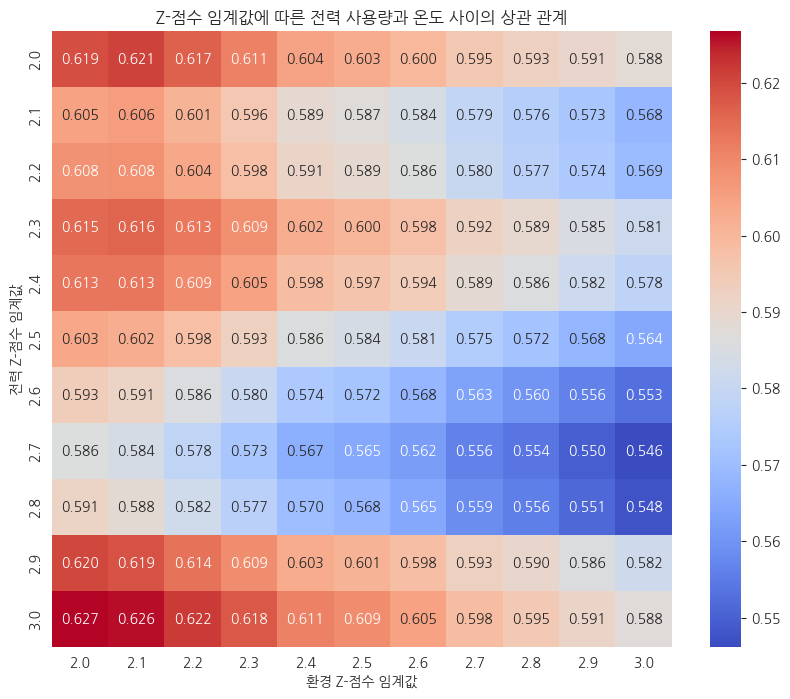

In [85]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 로드
temperature_df = pd.read_csv('cleaned_data/temperature/temperature_stats_cleaned.csv')
power_df = pd.read_csv('cleaned_data/power/power_stats_cleaned.csv')

# 이상치 제거 함수 (z-점수 사용)
def remove_outliers_by_zscore(df, column_name, z_thresh):
    df['z_score'] = zscore(df[column_name])
    return df[np.abs(df['z_score']) <= z_thresh].drop(columns=['z_score'])

# 각 데이터 세트에 대한 Z-점수 임계값 범위 지정
z_thresh_range_power = np.linspace(2.0, 3.0, 11)
z_thresh_range_env = np.linspace(2.0, 3.0, 11)

# 상관관계를 저장할 딕셔너리
correlation_results = {}

# 모든 조합의 z-점수 임계값에 대해 반복
for z_power in z_thresh_range_power:
    for z_env in z_thresh_range_env:
        # 이상치 제거
        temp_filtered_df = remove_outliers_by_zscore(temperature_df, 'value', z_env)
        power_filtered_df = remove_outliers_by_zscore(power_df, 'value', z_power)

        # 시간별 그룹으로 평균값 계산
        temp_avg = temp_filtered_df.groupby('time').value.mean().reset_index(name='avg_temperature')
        power_avg = power_filtered_df.groupby('time').value.mean().reset_index(name='avg_power_usage')

        # 데이터 프레임을 시간 기준으로 결합
        combined_data = pd.merge(temp_avg, power_avg, on='time')

        # 상관관계 계산
        correlation = combined_data[['avg_temperature', 'avg_power_usage']].corr().iloc[0, 1]
        correlation_results[(z_power, z_env)] = correlation

# 히트맵 데이터를 배열로 변환
correlation_matrix = np.array([[correlation_results[(z_power, z_env)] for z_env in z_thresh_range_env] for z_power in z_thresh_range_power])

# 히트맵 생성
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f",
            xticklabels=np.round(z_thresh_range_env, 1),
            yticklabels=np.round(z_thresh_range_power, 1))
plt.title('Z-점수 임계값에 따른 전력 사용량과 온도 사이의 상관 관계')
plt.xlabel('환경 Z-점수 임계값')
plt.ylabel('전력 Z-점수 임계값')
plt.show()

In [86]:
# 가장 높은 상관관계 점수 찾기
max_correlation_value = max(correlation_results.values())

# 해당 상관관계 점수에 해당하는 z-점수 임계값 찾기
max_correlation_thresholds = [thresholds for thresholds, correlation in correlation_results.items() if correlation == max_correlation_value]

# 결과 출력
print(f"최대 상관관계 점수: {max_correlation_value * 100:.2f}%")
print(f"해당 점수를 가진 Z-점수 임계값 조합: {max_correlation_thresholds}")

최대 상관관계 점수: 62.67%
해당 점수를 가진 Z-점수 임계값 조합: [(3.0, 2.0)]
